100%|██████████| 9912422/9912422 [00:00<00:00, 172233177.75it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 56978219.11it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49574150.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19990061.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

cuda:0
Epoch: 1
[1,  2000] loss: 1.133
[1,  4000] loss: 0.227
[1,  6000] loss: 0.166
[1,  8000] loss: 0.119
[1, 10000] loss: 0.096
[1, 12000] loss: 0.093
[1, 14000] loss: 0.080
[2,  2000] loss: 0.070
[2,  4000] loss: 0.068
[2,  6000] loss: 0.070
[2,  8000] loss: 0.053
[2, 10000] loss: 0.056
[2, 12000] loss: 0.056
[2, 14000] loss: 0.059
[3,  2000] loss: 0.042
[3,  4000] loss: 0.045
[3,  6000] loss: 0.045
[3,  8000] loss: 0.039
[3, 10000] loss: 0.048
[3, 12000] loss: 0.043
[3, 14000] loss: 0.048
[4,  2000] loss: 0.040
[4,  4000] loss: 0.031
[4,  6000] loss: 0.032
[4,  8000] loss: 0.037
[4, 10000] loss: 0.034
[4, 12000] loss: 0.034
[4, 14000] loss: 0.035
[5,  2000] loss: 0.024
[5,  4000] loss: 0.029
[5,  6000] loss: 0.020
[5,  8000] loss: 0.029
[5, 10000] loss: 0.030
[5, 12000] loss: 0.034
[5, 14000] loss: 0.029
Accuracy of the network on the 10000 test images: 99 %
[1,  2000] loss: 1.271
[1,  4000] loss: 0.547
[1,

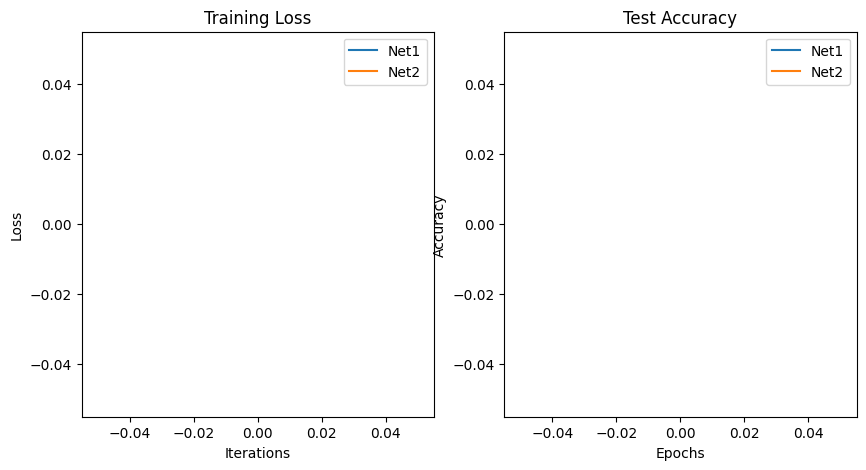

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# تعریف تبدیل‌های مورد نیاز برای تصویرها
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# بارگیری مجموعه داده‌ها
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

# تعریف دسته بندی‌ها
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# ایجاد دسته بندی‌ها
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# تعریف شبکه کانولوشنی اول
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# تعریف شبکه کانولوشنی دوم
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# تعریف تابع آموزش شبکه
def train(net, trainloader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

# تعریف تابع محاسبه دقت
def test(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

# تعریف تابع برای رسم نمودارها
def plot_graph(train_loss1, test_accuracy1, train_loss2, test_accuracy2):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss1, label='Net1')
    plt.plot(train_loss2, label='Net2')
    plt.title('Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracy1, label='Net1')
    plt.plot(test_accuracy2, label='Net2')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# تعریف دستگاه
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# تعریف شبکه‌ها و متغیرهای ضروری دیگر
net1 = Net1().to(device)
net2 = Net2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = torch.optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

# آموزش شبکه‌ها
train_loss1 = []
train_loss2 = []
test_accuracy1 = []
test_accuracy2 = []

for epoch in range(5):
    print("Epoch:", epoch+1)
    train(net1, trainloader, criterion, optimizer1)
    test_accuracy1.append(test(net1, testloader))
    train(net2, trainloader, criterion, optimizer2)
    test_accuracy2.append(test(net2, testloader))

plot_graph(train_loss1, test_accuracy1, train_loss2, test_accuracy2)


متاسفانه در بالا پلات رسم نشد ولی از خروجی ها و نحوه کم شدن لاس مشخص است

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # تبدیل تصویر به سه کانال
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# بارگیری مجموعه داده‌ها
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

# تعریف دسته بندی‌ها
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# ایجاد دسته بندی‌ها
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# بارگیری مدل MobileNetV2 از بیش آموزش دیده شده
model = models.mobilenet_v2(pretrained=True)

# تغییر آخرین لایه (fully connected layer) برای سازگاری با تعداد کلاس‌های ما
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)

# ارسال مدل به دستگاه (GPU یا CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# تعریف تابع آموزش مدل
def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

# تعریف تابع محاسبه دقت
def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

# تعریف تابع برای آموزش و تست مدل
def fine_tune_mobilenet(model, trainloader, testloader, criterion, optimizer, num_epochs=5):
    train_model(model, trainloader, criterion, optimizer, num_epochs)
    test_model(model, testloader)

# تعریف معماری مدل
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# آموزش و ارزیابی مدل
fine_tune_mobilenet(model, trainloader, testloader, criterion, optimizer)


[1,   200] loss: 0.574
[1,   400] loss: 0.095
[1,   600] loss: 0.067
[1,   800] loss: 0.052
[1,  1000] loss: 0.050
[1,  1200] loss: 0.044
[1,  1400] loss: 0.047
[1,  1600] loss: 0.039
[1,  1800] loss: 0.039
[2,   200] loss: 0.023
[2,   400] loss: 0.025
[2,   600] loss: 0.018
[2,   800] loss: 0.023
[2,  1000] loss: 0.021
[2,  1200] loss: 0.022
[2,  1400] loss: 0.025
[2,  1600] loss: 0.030
[2,  1800] loss: 0.024
[3,   200] loss: 0.024
[3,   400] loss: 0.016
[3,   600] loss: 0.014
[3,   800] loss: 0.020
[3,  1000] loss: 0.014
[3,  1200] loss: 0.014
[3,  1400] loss: 0.016
[3,  1600] loss: 0.018
[3,  1800] loss: 0.013
[4,   200] loss: 0.009
[4,   400] loss: 0.010
[4,   600] loss: 0.011
[4,   800] loss: 0.011
[4,  1000] loss: 0.013
[4,  1200] loss: 0.011
[4,  1400] loss: 0.014
[4,  1600] loss: 0.010
[4,  1800] loss: 0.012
[5,   200] loss: 0.008
[5,   400] loss: 0.009
[5,   600] loss: 0.006
[5,   800] loss: 0.008
[5,  1000] loss: 0.006
[5,  1200] loss: 0.008
[5,  1400] loss: 0.008
[5,  1600] 